In [2]:
#Import Libaries
import os
import time
import numpy as np 
from random import shuffle
# --- Signal Processing Libary
from scipy.io import wavfile
from scipy.signal import butter, lfilter, freqz, hilbert, filtfilt
import librosa
# --- Machine Learining
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


In [15]:
#Load dataset 
dataset_path = "datasetSTI/"
files = os.listdir(dataset_path)
OVdim = 700000 #Sample length (44.1kHz)
reDim = 253969 #Dimension after down sampling(16kHz)
X_data = np.zeros((len(files),OVdim))
Y_data = np.zeros((len(files),1))
X_data = X_data.astype('float32')
Y_data = Y_data.astype('float32') 
#smaller new dimension dataset
x_data = np.zeros((len(files),reDim))
x_data = X_data.astype('float32')
i=0
for wav in files:  
    #Read wav data
    if not wav.endswith(".wav"): continue
    Fs,signal = wavfile.read(dataset_path+wav)
    X = np.array(signal)
    if(OVdim-len(X)>0):
        Xpad = np.pad(X, (0, OVdim-len(X)), mode='constant')
        X_data[i]=np.array(Xpad)
        #Read label (Speech Transmission Idex) from file name
        rt = int(wav[0:4])
        rt /=10000
        Y_data[i] = rt
        i += 1
    else:
        print("dimension is not enought for some records!")

### Down sampling to 16kS/s

In [17]:
x_data = librosa.resample(X_data, Fs, 16000)

Dimension at 44.1 kS/s : 700000
Dimension at 16.0 kS/s : 253969


### Split dataset

In [24]:
#Seperating dataset to Tune, Train and test Set
index = np.linspace(0,len(files)-1,len(files))
shuffle(index) #Shuffle Data

tuningSet = 20
trainingSet = 70
testSet = len(files)- noTune - noTrain

x_tune = np.zeros([tuningSet,reDim])#5000
y_tune = np.zeros([tuningSet,1])
x_train = np.zeros([trainingSet,reDim])#30000
y_train = np.zeros([trainingSet,1])
x_test = np.zeros([testSet,reDim])#the least
y_test = np.zeros([testSet,1])
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_tune = x_tune.astype('float32')
y_tune = y_tune.astype('float32')
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

for i in range(20):
    x_tune[i]= x_data[int(index[i])]
    y_tune[i]= Y_data[int(index[i])]
j=0
for i in range(20,90):
    x_train[j]= x_data[int(index[i])]
    y_train[j]= Y_data[int(index[i])] 
    j +=1
j=0    
for i in range(90,len(files)):
    x_test[j]= x_data[int(index[i])]
    y_test[j]= Y_data[int(index[i])]
    j +=1


### Sub-band Envelope Extraction

In [11]:
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

fcentre = [125,250,500,1000,2000,4000,8000] # Center freq.-Octave band 
fc = 30 # cutoff frequency of the speech envelope  at 30 Hz
w_L = 2*fc/Fs

bz, az = butter(6,w_L, 'low')#lowpas filter order '6'
fd = np.power(2,1/2)

Fs = 16000 #441000 #new Sampling rate

y_subband = np.zeros([7,reDim])
y_env = np.zeros([7,reDim])
y_env_rs = np.zeros([7,2000])
y_env_ds = np.zeros([7,1588])

In [ ]:
x_tune_fea= np.zeros([len(x_tune),6352])
x_tune_fea = x_tune_fea.astype('float32')

for k in range(1):#(len(x_tune)):
    for i in range(3,7):
        highcut = fcentre[i] *fd
        lowcut = fcentre[i]/fd
        b, a = butter_bandpass(lowcut, highcut, Fs, order=6)      
        
        y_subband[i] = filtfilt(b,a,x_tune[k])     #Octave filter
        y_env[i] = filtfilt(bz,az,np.abs(hilbert(y_subband[i])))  #Envelope extraction
        #y_env_ds[i] = librosa.resample(y_env[i], Fs, 100)
    
    Env_concat = np.hstack((y_env_ds[3],y_env_ds[4],y_env_ds[5],y_env_ds[6]))     
    #x_tune_fea[k] =  librosa.util.normalize(Env_concat, fill=True) #Normalized   
      

In [ ]:
x_train_fea= np.zeros([len(x_tune),6352])
x_train_fea = x_train_fea.astype('float32')

for k in range(len(x_train)):
    for i in range(3,7):
        highcut = fcentre[i] *fd
        lowcut = fcentre[i]/fd
        b, a = butter_bandpass(lowcut, highcut, Fs, order=6)      
        
        y_subband[i] = filtfilt(b,a,x_rain[k])     #Octave filter
        y_env[i] = filtfilt(bz,az,np.abs(hilbert(y_subband[i])))  #Envelope extraction
        y_env_ds[i] = librosa.resample(y_env[i], Fs, 100)
    
    Env_concat = np.hstack((y_env_ds[3],y_env_ds[4],y_env_ds[5],y_env_ds[6]))     
    x_train_fea[k] =  librosa.util.normalize(Env_concat, fill=True) #

In [ ]:
x_test_fea= np.zeros([len(x_tune),6352])
x_test_fea = x_test_fea.astype('float32')

for k in range(1):#(len(x_tune)):
    for i in range(3,7):
        highcut = fcentre[i] *fd
        lowcut = fcentre[i]/fd
        b, a = butter_bandpass(lowcut, highcut, Fs, order=6)      
        
        y_subband[i] = filtfilt(b,a,x_test[k])     #Octave filter
        y_env[i] = filtfilt(bz,az,np.abs(hilbert(y_subband[i])))  #Envelope extraction
        y_env_ds[i] = librosa.resample(y_env[i], Fs, 100)
    
    Env_concat = np.hstack((y_env_ds[3],y_env_ds[4],y_env_ds[5],y_env_ds[6]))     
    x_tune_fea[k] =  librosa.util.normalize(Env_concat, fill=True) #Normalized   

In [ ]:
plt.subplot(211)
plt.plot(y_env[3])
plt.subplot(213)
plt.plot(y_env[4])
plt.subplot(221)
plt.plot(y_env[5])
plt.subplot(222)
plt.plot(y_env[6])

In [ ]:
#save features array to file (.npy)
np.save('x_tune_fea', x_tune_fea)
np.save('x_train_fea', x_train_fea)
np.save('x_test_fea', x_test_fea)
np.save('y_tune', y_tune)
np.save('y_train', y_train)
np.save('y_test', y_test)

### Create the network 

In [ ]:
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset but only keep the top n words, zero the rest
top_words = 2000
embedding_vecor_length = 32

model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=2724))
model.add(LSTM(10))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy','mse'])
print(model.summary())

model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1)

# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length,
                    input_length=max_review_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same',
                 activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, padding='same',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128, drop_out = 0.5))
model.add(Dense(1, activation='sigmoid'))
model.add(LSTM(128))
model.add(Dense(1, activation='linear'))
#optimizer='adam'
model.compile(loss='mse', 
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

### Tuning

In [ ]:
model.fit(x_tune, y_tune, epochs=3, batch_size=5,shuffle=True, verbose=1,validation_split=0.2)

### Training

In [ ]:
model.fit(x_train, y_train, epochs=20, batch_size=64,shuffle=True  verbose=0)

### Evaluate the model

In [ ]:
#---------------- Evaluation ---------------
scores = model.evaluate(x_test_fea,y_test, verbose=0)
y_estimation = model.predict(x_test_fea)

accuracy = metrics.r2_score(y_test, y_estimation)
print ("Cross-Predicted Accuracy:", accuracy)
print("%s:%.3f%%"%(model.metrics_names[0],score[1]*100))
print("RMSE:%.3f",np.sqrt(metrics.mean_squared_error(y_test,y_estimation)))

### Save the trained model 

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

*-------------- End of Code --------------------

### *-------------- debug session ---------------------*

In [ ]:
import matplotlib.pyplot as plt 
%matplotlib inline
print("Input",X_data.shape)
print("Target",Y_data.shape)
print("Sampling Rate :",Fs)

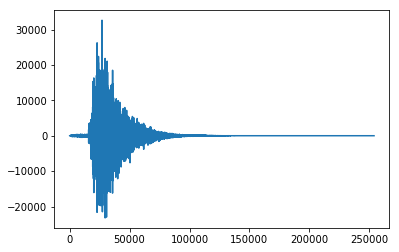

In [44]:
plt.plot(x_tune[3])

In [45]:
print("Dimension at 44.1 kS/s : %d" %len(X_data[3]))
print("Dimension at 16.0 kS/s : %d" %len(x_test[3]))

Dimension at 44.1 kS/s : 700000
Dimension at 16.0 kS/s : 253969
